<a href="https://colab.research.google.com/github/M10Tejaswini/bank-customer-churn-prediction-with-shap-lime/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# === Bank Customer Churn Prediction (Colab + Kaggle) ===

This notebook downloads a churn dataset from Kaggle, prepares the data, trains a Random Forest to predict churn, evaluates the model, and explains model behavior using SHAP (global + local insight) and LIME (local explanations).

* SHAP = SHapley Additive exPlanations. SHAP is based on Shapley values, a concept from cooperative game theory.


* SHAP explains machine learning predictions by assigning each feature a fair contribution score — using math from game theory — to show why a model predicted what it did.

* SHAP calculates fair contribution for each member, even if they collaborate or interact.
This “fairness” is what makes SHAP scientifically strong.

# Step 1: Install SHAP


In [ ]:
!pip install shap --quiet

- What it does: installs the SHAP library into the Colab environment.
- Why: SHAP isn’t included in base environments; you must install it first.
- Tip: add --quiet to reduce noise; remove it if you want installation logs.

# Step 2: Upload Kaggle API Key

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maroliatejaswini","key":"3e4b00d54b0330fb8aa8a18cc63c9a5a"}'}

- What it does: opens a browser file picker in Colab so you can upload kaggle.json.
- Why: Kaggle credentials (a JSON file) are needed to use the Kaggle CLI to download datasets.
- Tip: keep kaggle.json private — it contains your API token.

# Step 3: Set up Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

- What this does: copies the uploaded kaggle.json into Colab’s home directory and tightens file permissions.
- Why: the Kaggle CLI looks for credentials at ~/.kaggle/kaggle.json and requires secure permissions.
- Pitfall: if you forget chmod 600, the Kaggle CLI may fail for security reasons.

In [ ]:
!kaggle datasets list -s "bank customer churn"


ref                                                   title                                            size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  -----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
radheshyamkollipara/bank-customer-churn               Bank Customer Churn                            314688  2023-04-28 16:32:01.277000          30590        232  1.0              
gauravtopre/bank-customer-churn-dataset               Bank Customer Churn Dataset                    191965  2022-08-30 15:01:34.427000          34525        213  1.0              
shantanudhakadd/bank-customer-churn-prediction        Bank Customer Churn Prediction                 267794  2022-03-19 04:05:12.343000          15838        119  0.9705882        
mathchi/churn-for-bank-customers                      Churn for Bank Customers                 

- What it does: searches Kaggle for datasets matching the query string and lists results.
- Why: helpful to find the exact dataset and verify dataset IDs before downloading.
- Tip: note the dataset ref (e.g. radheshyamkollipara/bank-customer-churn) — use that with kaggle datasets download -d.

# Step 4: Download the dataset from Kaggle

In [ ]:
!kaggle datasets download -d radheshyamkollipara/bank-customer-churn


Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
License(s): other
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 669MB/s]


# Step 5: Unzip the dataset

In [ ]:
!unzip -o bank-customer-churn.zip

Archive:  bank-customer-churn.zip
  inflating: Customer-Churn-Records.csv  


- What it does: downloads the chosen dataset zip and extracts its files into the notebook working directory.
- Why: quickly get the CSV file(s) into Colab so you can read them with pandas.
- Tip: -o overwrites files when unzipping; good when re-running the notebook.


# Step 6: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap


* What it does: loads Python packages needed for data handling, plotting, modeling and model
* Why: each library has a role: pandas/numpy for data, sklearn for modeling, shap for explanations.
* Tip: import only what you use; keep versions reproducible (e.g., pip freeze).

# Step 7: Load Dataset

In [ ]:
data = pd.read_csv('Bank Customer Churn Prediction.csv')
print("First 5 rows:\n", data.head())
print("\nDataset Info:")
print(data.info())

First 5 rows:
    customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (tota

* What it does: reads the CSV into a DataFrame and shows the first rows and column types.
* Why: quick sanity check — confirms columns, types, missing values and dataset size.
* Tip: always inspect data.describe() and data.isna().sum() if you need more checks.

# Step 8: Encode categorical columns for correlation and modeling

In [ ]:
categorical_cols = ['country', 'gender']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])


* What it does: converts string categories into integer labels.
* Why: many ML models (and some tools like SHAP) require numeric input. LabelEncoder gives each category an integer code.
When to use caution: LabelEncoder imposes an ordinal relationship — fine for tree models but problematic for linear models. For one-hot needs, use pd.get_dummies() or OneHotEncoder.
* Tip: save encoders if you want to transform new data consistently.

# Step 9: Exploratory Data Analysis (EDA)

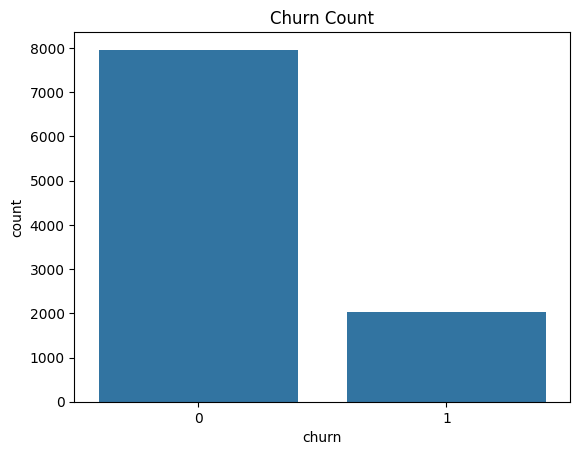

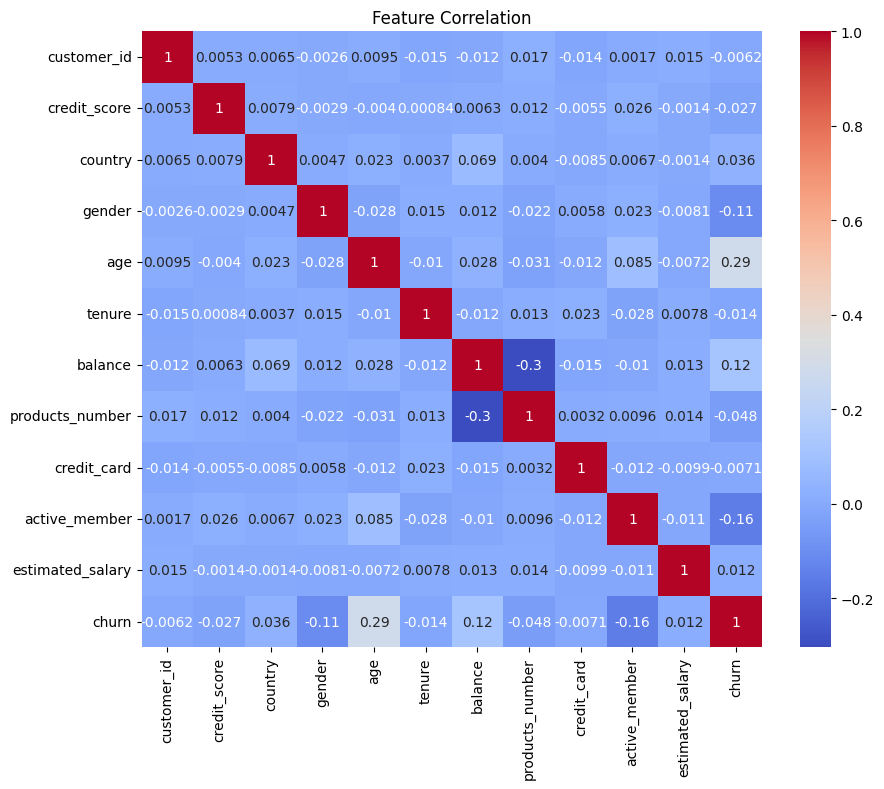

In [ ]:
# Count of churned vs retained customers
sns.countplot(x='churn', data=data)
plt.title('Churn Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

* What it does: visualizes target class balance and feature correlations.
* Why: helps identify class imbalance and correlated features that might influence modeling or multicollinearity.
* Tip: if classes are imbalanced, consider stratified splitting, resampling, or using class weights.

#Step 10: Data Preprocessing

In [ ]:
# Features and target
X = data.drop(['churn', 'customer_id'], axis=1)  # Drop customer_id
y = data['churn']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert X_test back to DataFrame for SHAP compatibility
X_test_df = pd.DataFrame(X_test, columns=X.columns)



What it does:

* Drops ID and target to create X and y.

* Standardizes features to zero mean and unit variance.

* Splits data into training and test sets.

* Wraps X_test back into a DataFrame for readability/compatibility (useful for SHAP column names).

* Why: scaling helps many algorithms (and keeps feature scales comparable); the train/test split assesses generalization. X_test_df keeps column names for plotting/explainers.

Pitfalls & tips:

* Fit the scaler on training data only (you do that with fit_transform(X) before split — better practice is fit on X_train only then transform both sets). Current flow fits on full X — acceptable in simple demos but leaks information. Fix: scale after splitting: scaler.fit(X_train) then X_train = scaler.transform(X_train) and X_test = scaler.transform(X_test).

* Keep the scaler object so you can inverse-transform values for interpretability if needed.

# Step 11: Build Model


In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

**What it does:**
* trains a tree-based classifier and produces class predictions and probabilities for the test set.
* Why: Random Forests work well off-the-shelf, handle categorical-coded features, and give feature importance. predict_proba yields probabilities needed for AUC and some explanation methods.

* Tip: set class_weight='balanced' if the classes are imbalanced, or tune hyperparameters.

# Step 12: Evaluate Model

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.57       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

ROC-AUC Score: 0.8566917002744039


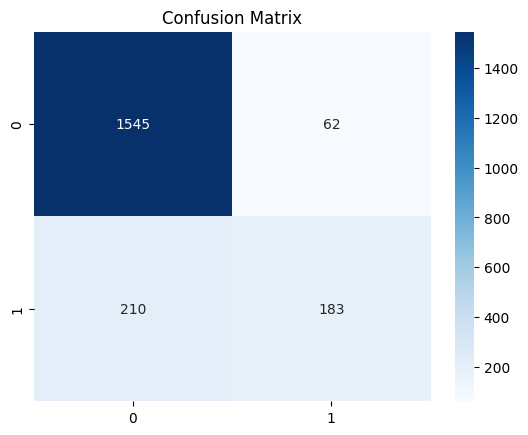

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**What it does & why:**

* classification_report shows precision, recall, f1-score per class — helpful to see where the model struggles (e.g., recall for churn class).

* roc_auc_score measures discrimination ability of predicted probabilities (1.0 perfect, 0.5 random).

* The confusion matrix shows true/false positives/negatives — crucial in churn where false negatives (missed churners) may be costly.

* Interpretation tip: high accuracy can hide poor recall for minority class. In your output, recall for churn (class 1) is low → model misses many churners.

# Step 13: Feature Importance with SHAP

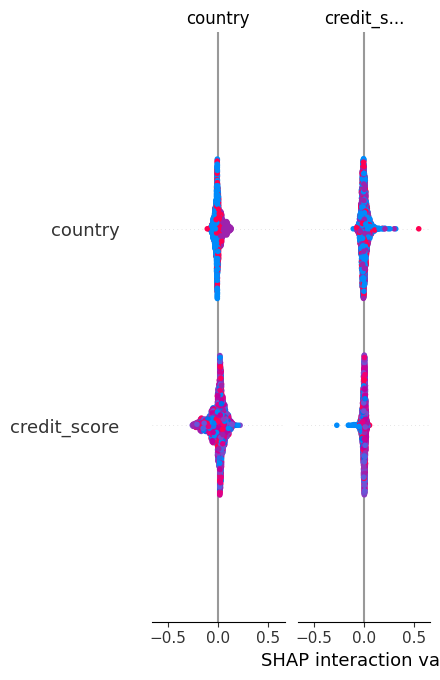

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# Handle binary/multi-class SHAP output safely
if isinstance(shap_values, list):
    # Binary classification: plot class 1
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_df, feature_names=X.columns)

**What it does:**

* TreeExplainer(model) creates a SHAP explainer optimized for tree models.

* explainer.shap_values(X_test_df) computes SHAP values for samples in X_test_df.

* The code checks whether SHAP returned a list (older SHAP or multi-class => list per class); for binary, plotting class-1 SHAP makes sense.

* summary_plot displays global importance and how feature values push predictions up/down.

* Why: SHAP gives fair, additive attributions — you can see which features influence churn predictions and whether higher/lower values push probability up or down.

**Important notes & pitfalls:**

* Always pass a DataFrame (with column names) or supply feature_names so plots are labeled.

* SHAP can return either a single (n_samples, n_features) array or a list of arrays for classes — that’s why code checks type.

* For tree models, TreeExplainer is fast and exact for many tree implementations.



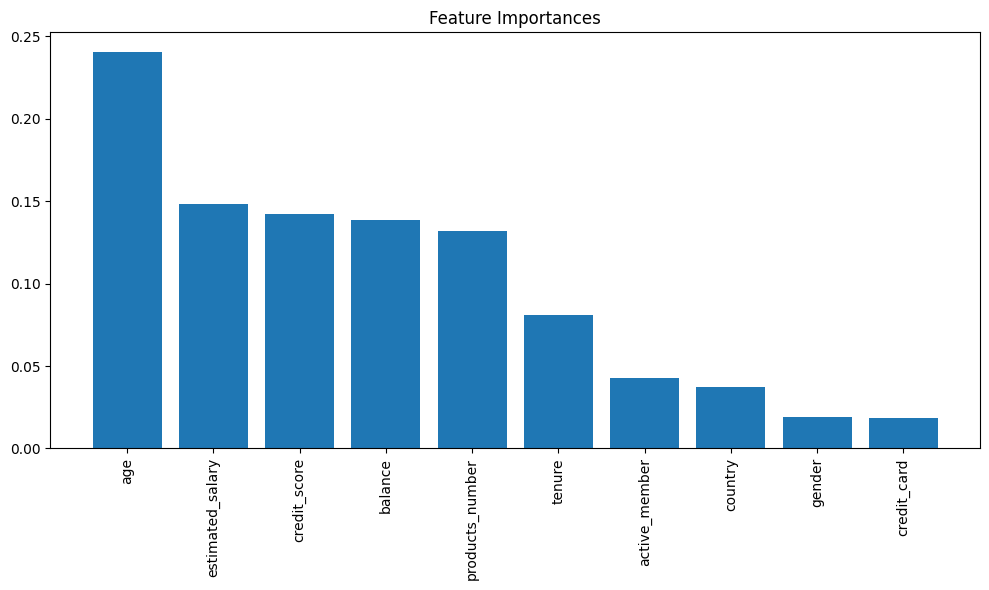

In [ ]:
# Bar plot for feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

* What it does: shows the model’s built-in feature importance (based on impurity reduction).
* Why & caveat: quick global importance, but impurity-based importances can be biased (toward high-cardinality features). SHAP is generally more reliable and interpretable.

# Step 14: Install LIME

In [ ]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


* What it does: installs the LIME package for local explanations.

#Step 15: Import LIME

In [ ]:
from lime.lime_tabular import LimeTabularExplainer


* What it does: imports the tool used to explain individual predictions by approximating the model locally with interpretable surrogates.

#Step 16: Initialize LIME Explainer

In [ ]:
# training data (unscaled is better for interpretability)
explainer_lime = LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['Retained', 'Churned'],
    discretize_continuous=True,
    mode='classification'
)

* **What it does:** builds a LIME explainer using training data as the neighborhood reference.
* Why: LIME perturbs the training data space to fit a simple interpretable model locally around the instance being explained. discretize_continuous=True bins continuous features to make explanations easier to read.

* Important: LIME assumes the data you provide to it is in the same format the model expects. Since you trained on scaled data, you passed scaled X_train. Often, humans prefer unscaled values for interpretation — either:

* Initialize LIME with unscaled features and wrap the model in a function that scales inputs before prediction, or

* Use scaled data but remember to inverse-transform feature values when you present explanations.

#Step 17: Explain a Single Prediction

In [ ]:
i = 0  # Index of the test sample to explain
exp = explainer_lime.explain_instance(
    X_test[i],  # Use the raw scaled vector
    model.predict_proba,
    num_features=5  # Show top 5 contributing features
)

# Display LIME explanation in notebook
exp.show_in_notebook(show_table=True)


**What it does:**

* explain_instance perturbs the selected test sample, gets model predictions for the perturbed samples, fits a simple interpretable model (like a sparse linear model) locally, and returns contributions for features.

* show_in_notebook displays a neat explanation table/plot.

* Why: LIME gives local explanations (how features influenced that single prediction). It’s complementary to SHAP — SHAP has a stronger theoretical basis (Shapley values), LIME is more heuristic but intuitive.



